Most AI of autonmous vehicles (AVs) comes not standalone but rather with a large number of rules ans heuristics that restrict what actions the AI takes or can take. This primarily relates to managing risks, such as those resulting from collisions or crashes.

There are number of standard risk measures that are typically used, such as (trailing) stop loss orders or take profit orders. How such risk measures are handles is a matter of human judgement. AI provides improved predictions, but human judgement still plays a role in setting decision rules and action boundaries.

First, it backtests in both vectorized and event-based fashio algorithm trading strategies that result from a trained deep Q-learning agent called trading bots.

Second, it assesses risks related to the financial instrument on which the strategies are implemented on which the strategies are implemented.

Third, it backtests typical risk measures using the event-based approach. The major benefit of event-based backtesting when compared to vectorized backtesting is higher degree of flexibility in modeling and analyzing decision rule and risk management measures.

# Trading Bot

This section presents a trading bot based on the financial Q-learning agent, `FQLAgent`.

In [85]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl

import warnings
warnings.filterwarnings('ignore')

We use `finance` class and `tradingbot` class

In [86]:
%load_ext autoreload
%autoreload 2
import finance
import tradingbot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
symbol = "EUR="
features = [symbol, 'r', 's', 'm', 'v']

In [88]:
a = 0
b = 1750
c = 250

In [89]:
learn_env = finance.Finance(symbol, features, window=20, lags=3,
                            leverage=1, min_performance=0.9, min_accuracy=0.475,
                            start=a, end=a+b, mu=None, std=None)

In [90]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1750 entries, 2010-02-02 to 2017-01-12
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    1750 non-null   float64
 1   r       1750 non-null   float64
 2   s       1750 non-null   float64
 3   m       1750 non-null   float64
 4   v       1750 non-null   float64
 5   d       1750 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 88.9 KB


In [91]:
valid_env = finance.Finance(symbol, features=learn_env.features,
                            window=learn_env.window,
                            lags=learn_env.lags,
                            leverage=learn_env.leverage,
                            min_performance=0.0, min_accuracy=0.0,
                            start=a+b, end=a+b+c,
                            mu=learn_env.mu, std=learn_env.std)

In [92]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2017-01-13 to 2018-01-10
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    250 non-null    float64
 1   r       250 non-null    float64
 2   s       250 non-null    float64
 3   m       250 non-null    float64
 4   v       250 non-null    float64
 5   d       250 non-null    int32  
dtypes: float64(5), int32(1)
memory usage: 12.7 KB


In [93]:
tradingbot.set_seeds(100)
agent = tradingbot.TradingBot(24, 0.001, learn_env, valid_env)

In [94]:
episodes = 61

In [95]:
%time agent.learn(episodes)

episode: 10/61 | VALIDATION | treward:  247 | perf: 1.094 | eps: 0.92
episode: 20/61 | VALIDATION | treward:  247 | perf: 1.089 | eps: 0.83
episode: 30/61 | VALIDATION | treward:  247 | perf: 0.932 | eps: 0.75
episode: 40/61 | VALIDATION | treward:  247 | perf: 1.003 | eps: 0.68
episode: 50/61 | VALIDATION | treward:  247 | perf: 0.998 | eps: 0.62
episode: 60/61 | VALIDATION | treward:  247 | perf: 0.951 | eps: 0.56
episode: 61/61 | treward: 1747 | perf: 1.258 | av: 377.2 | max: 1747
CPU times: total: 1.81 s
Wall time: 34.7 s


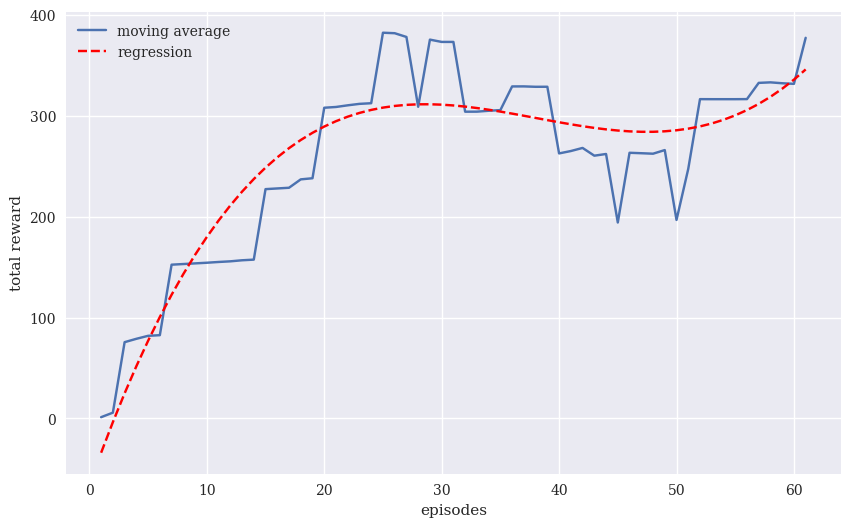

In [96]:
tradingbot.plot_treward(agent)

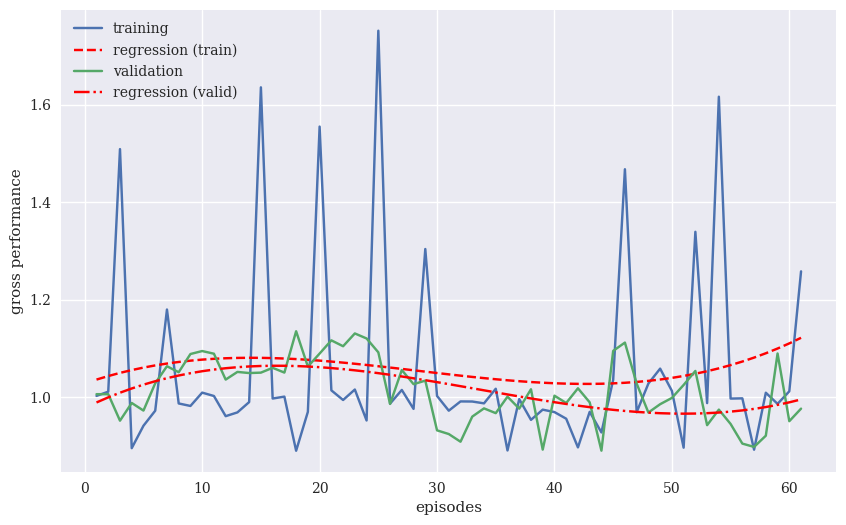

In [97]:
tradingbot.plot_performance(agent)

# Vectorized Backtesting

In DNN context, the data with the feature and labels sub-sets is prepared first and then fed to the DNN to generate all predictions at once. In a reinforcement learning (RL) context, data is generated and collected by interacting with the environment action by action and step by step.

In [98]:
def reshape(s):
    # reshape a single feature-label combination
    return np.reshape(s, [1, learn_env.lags, learn_env.n_features])

In [99]:
def backtest(agent, env):
    env.min_accuracy = 0.0
    env.min_performance = 0.0
    done = False
    # generates a column for the position values
    env.data['p'] = 0
    state = env.reset()
    while not done:
        action = np.argmax(
            # derives the optimal action (prediction) given the trained DNN
            agent.model.predict(reshape(state))[0, 0]
        )
        # derives the resulting position (+1 for long/upwards, -1 for short/downwards)
        position = 1 if action == 1 else -1
        # stores in the corresponding column at the appropriate index position
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action)
    # calculates the strategy log return given the position values
    env.data['s'] = env.data['p'] * env.data['r'] * learn_env.leverage

In [100]:
# specifies the relevant environment
env = agent.learn_env

In [101]:
# generates the additional data required
backtest(agent, env)

In [102]:
# counts the number of long and short positions
env.data['p'].iloc[env.lags:].value_counts()

p
 1    1041
-1     706
Name: count, dtype: int64

In [103]:
# calculates the gross performances for the passive benchmark investment (r) and the strategy (s)
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r    0.772535
s    1.685486
dtype: float64

In [104]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

r   -0.227465
s    0.685486
dtype: float64

<Axes: xlabel='Date'>

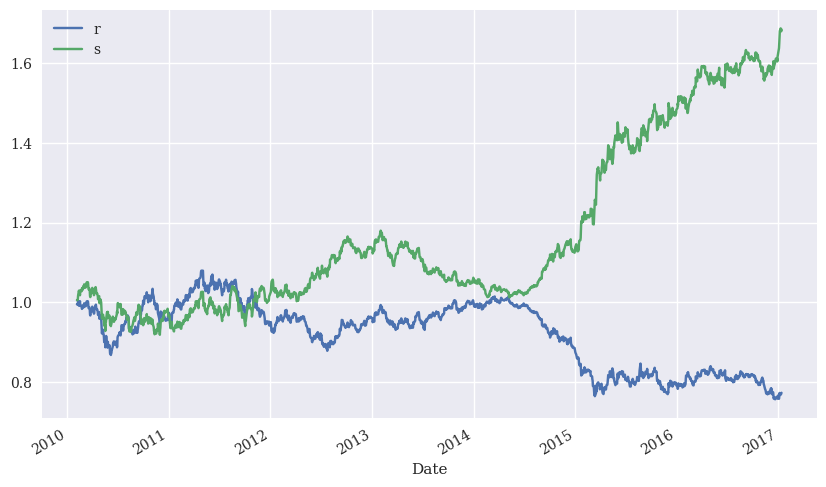

In [105]:
env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6))

To get a more realistic picture of the performance of the trading bot, the following code creates a test environment with data that the trading bot has not yet seen.

In [106]:
test_env = finance.Finance(symbol, features=learn_env.features,
                           window=learn_env.window,
                           lags=learn_env.lags,
                           leverage=learn_env.leverage,
                           min_performance=0.0, 
                           min_accuracy=0.0,
                           start=a+b+c, end=None,
                           mu=learn_env.mu, std=learn_env.std)

In [107]:
env = test_env

In [108]:
backtest(agent, env)

In [109]:
env.data['p'].iloc[env.lags:].value_counts()

p
-1    255
 1    238
Name: count, dtype: int64

In [110]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r    0.914430
s    0.857956
dtype: float64

In [111]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

r   -0.085570
s   -0.142044
dtype: float64

<Axes: xlabel='Date'>

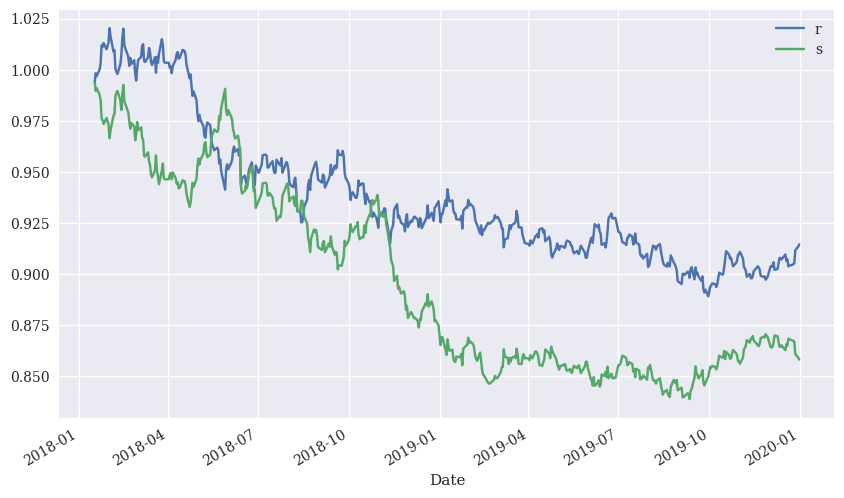

In [112]:
env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6))

To be able to judge the real performance of a trading strategy, risk measures should be included. 

# Event-Based Backtesting

To be able to properly analyze risk measures, such as trailing stop loss orders, event-based backtesting is required.

`get_date_price()`
For a given bar (index value for the DataFrame object containing the financial data), it returns the relevant date and price.

`print_balance()`
For a given bar, it prints the current (cash) balance of the trading bot.

`calculate_net_wealth()`
For a given price, it returns the net wealth composed of the current (cash) balance and the instrument position.

`print_net_wealth()`
For a given bar, it prints the net wealth of the trading bot.

`place_but_order()`, `place_sell_order()`
For a given bar and a given number of units or a given amount, these methods place buy or sell orders and adjust relevant quantities accordingly.

`close_out()`
At a given bar, this method closes open postions and calculates and reports performance statistics.



In [113]:
import backtesting as bt

In [114]:
# instantiates a Backtesting object
bb = bt.BacktestingBase(env=agent.learn_env, model=agent.model,
                        amount=10000, ptc=0.0001, ftc=1.0, verbose=True)

In [115]:
# initial amount attribute
bb.initial_amount

10000

In [116]:
# fixes bar value
bar = 100

In [117]:
# retrieves the date and price values for the bar
bb.get_date_price(bar)

('2010-06-25', 1.2374)

In [118]:
# retrieves the state of the Finance environment for the bar
bb.env.get_state(bar)

,EUR=,r,s,m,v
Date,,,,,
2010-06-22,-0.024193,-0.562226,-0.091601,-0.202232,1.531581
2010-06-23,0.017620,0.693976,-0.093921,-0.091539,1.556293
2010-06-24,0.035412,0.303386,-0.086514,0.639094,1.089033


In [119]:
# places a buy order using the amount parameter
bb.place_buy_order(bar, amount=5000)

2010-06-25 | buy 4040 units for 1.2374
2010-06-25 | current balance = 5001.40


In [120]:
# prints the net wealth at a later point (2 * bar)
bb.print_net_wealth(2 * bar)

2010-11-16 | net wealth = 10452.17


In [121]:
# places a sell order at that later point using the units parameter
bb.place_sell_order(2 * bar, units=1000)

2010-11-16 | sell 1000 units for 1.3492
2010-11-16 | current balance = 6349.47


In [122]:
# closes out the remaining long position even later (3 * bar)
bb.close_out(3 * bar)

2011-04-11 | *** CLOSING OUT ***
2011-04-11 | sell 3040 units for 1.4434
2011-04-11 | current balance = 10735.97
2011-04-11 | net performance [%] = 7.3597
2011-04-11 | number of trades [#] = 3


In [123]:
# event-based backtesting for the trading bot
class TBBacktester(bt.BacktestingBase):
    def _reshape(self, state):
        '''
        helper method to reshape state objects
        '''
        return np.reshape(state, [1, self.env.lags, self.env.n_features])
    
    def backtest_strategy(self):
        '''
        Event-based backtesting of the trading bot's performance
        '''
        self.untis = 0
        self.position = 0
        self.trades = 0
        self.current_balance = self.initial_amount
        self.net_wealths = list()
        for bar in range(self.env.lags, len(self.env.data)):
            date, price = self.get_date_price(bar)
            if self.trades == 0:
                print(50 * '=')
                print(f'{date} | *** START BACKTEST ***')
                self.print_balance(bar)
                print(50 * '=')
            # retrieves the state of the Finance environment
            state = self.env.get_state(bar)
            # generates the optimal action (prediction) given the state and the model object
            action = np.argmax(self.model.predict(self._reshape(state.values))[0, 0])
            # derives the optimal postion (long/short) given the optimal action (prediction)
            position = 1 if action == 1 else -1
            # enters a long positoin if the conditions are met
            if self.position in [0, -1] and position == 1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING LONG ***')
                if self.position == -1:
                    self.place_buy_order(bar - 1, units=-self.units)
                    self.place_buy_order(bar - 1,
                                         amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = 1
            
            # enters a short position if the conditions are met
            elif self.position in [0, 1] and position == -1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING SHORT ***')
                if self.position == 1:
                    self.place_sell_order(bar - 1, units=self.units)
                self.place_sell_order(bar - 1, amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = -1
            
            # collects the net wealth values over time and transforms them into a DataFrame object
            self.net_wealths.append((date, self.calculate_net_wealth(price)))
        self.net_wealths = pd.DataFrame(self.net_wealths, columns=['date', 'net_wealth'])
        self.net_wealths.set_index('date', inplace=True)
        self.net_wealths.index = pd.DatetimeIndex(self.net_wealths.index)
        self.close_out(bar)  
                    

In [124]:
env = learn_env

In [125]:
# event-based backtest in-sample without transaction costs
tb = TBBacktester(env, agent.model, 10000, 0.0, 0, verbose=False)

In [126]:
tb.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 16411.95
2017-01-12 | net performance [%] = 64.1195
2017-01-12 | number of trades [#] = 804


In [127]:
# event-based backtest in-sample with transaction costs
tb_ = TBBacktester(env, agent.model, 10000, 0.00012, 0.0, verbose=False)

In [128]:
tb_.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 16411.43
2017-01-12 | net performance [%] = 64.1143
2017-01-12 | number of trades [#] = 804


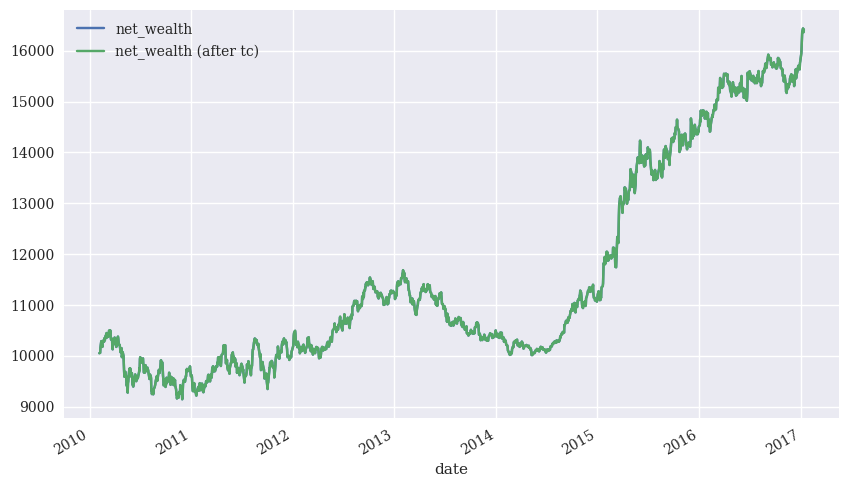

In [129]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);